In [1]:
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
%matplotlib inline
plt.style.use('seaborn')

We will analyze portfolios with assets from the big four.

In [2]:
adjJ = pd.read_csv('adjJoined.csv', index_col='Date')

In [3]:
big4Df = adjJ[['AMZN', 'AAPL', 'GOOGL', 'FB']]

In [4]:
big4Df1 = big4Df.loc[(big4Df.index>='2015-01-01') & (big4Df.index<='2017-12-31')]
big4Df2 = big4Df.loc[(big4Df.index>='2015-01-01')]

In [5]:
big4Df1.head()

,AMZN,AAPL,GOOGL,FB
Date,,,,
2015-01-02,308.519989,101.528191,529.549988,78.449997
2015-01-05,302.190002,98.667984,519.460022,77.190002
2015-01-06,295.290009,98.677261,506.640015,76.150002
2015-01-07,298.420013,100.060936,505.149994,76.150002
2015-01-08,300.459991,103.905510,506.910004,78.180000


In [6]:
#converts the row indices into datetime
big4Df1.index = pd.to_datetime(big4Df1.index)
big4Df2.index = pd.to_datetime(big4Df2.index)

In [7]:
numAssets1 = len(big4Df.columns)
numAssets2 = len(big4Df.columns)

/Users/owenren/anaconda3/envs/FinancialAnalysis/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


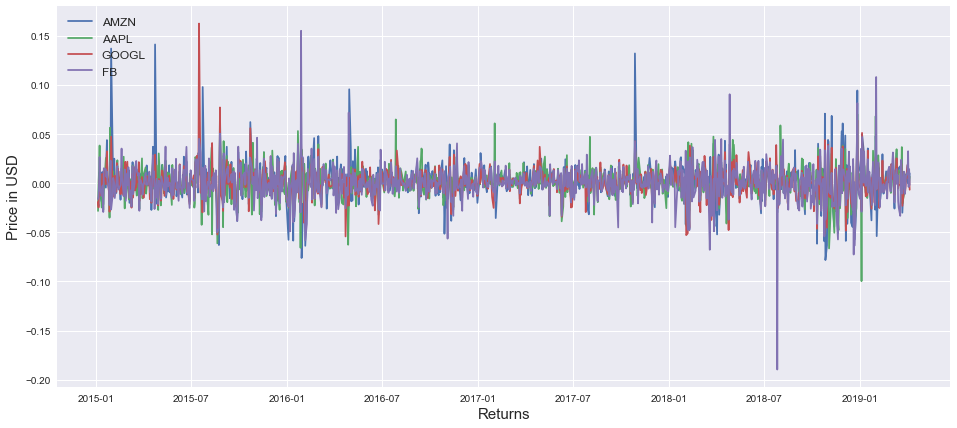

In [8]:
#daily return of these stocks
retDaily = big4Df2.pct_change()

plt.figure(figsize=(16, 7))
for c in retDaily.columns.values:
    plt.plot(retDaily.index, retDaily[c], label=c)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('Price in USD', fontsize=15)
plt.xlabel('Returns', fontsize=15)
plt.show()

https://www.marketwatch.com/story/facebook-stock-crushed-after-revenue-user-growth-miss-2018-07-25

In [9]:
from IPython.display import display, Math, Latex

Modern portfolio theory says that it is not enough to look at the expected risk and return of one particular stock. By investing in more than one stock, an investor can reap the benefits of diversification – chief among them, a reduction in the riskiness of the portfolio. We will look for optimal portfolios by exhibiting a monte carlo simulation of random portfolios and then graphing the return vs risk, where risk (volatility) is measured in terms of standard deviation.

From the edge of the graph, we can find the 'efficient frontier', which is the set of optimal portfolios that offer the highest expected return for a defined level of risk or the lowest risk for a given level of expected return. Portfolios that lie below the efficient frontier are sub-optimal because they do not provide enough return for the level of risk. Portfolios that cluster to the right of the efficient frontier are sub-optimal because they have a higher level of risk for the defined rate of return.

ASSUMPTIONS OF MPT
- Investors are rational and avoid risks whenever possible
- Investors aim for the maximum returns for their investment
- All investors share the aim maximizing their expected returns
- Commissions and taxes on the market are left out of consideration
- All investors have access to the same sources and level of all necessary information about investment decisions
- Investors have unlimited access to borrow and lend money at the risk free rate

In terms of mathematics, a portfolio $P$ is a affine linear combination of the return rates 
$X_1,X_2,...,X_n$ (can be in days, weeks, months or years) of assets numbered $1,2,..,n$, i.e., 
$$\begin{align}P = \sum_{i=1}^n\omega_iX_i\quad\text{where}\quad\sum_{i=1}^n\omega_i = 1\end{align}.$$ 
In our example $n=4$, as we are considering four stocks.

In [10]:
#Set labels for the big four companies
labels = ['AMAZON', 'APPLE', 'GOOGLE', 'FACEBOOK']
#Set number of portfolios to be generated. Must be a large number
numPortf = 60000

In [11]:
def annData(df):
    retsDaily = df.pct_change().dropna()
    covDaily = retsDaily.cov()
    retsA = retsDaily.mean()*252
    covA = covDaily*252
    return retsA, covA
#for weekly covariance, use covWeekly1 = covDaily1*5
#for monthly covariance, use covMonthly1 = covDaily1*21

In [12]:
retsAnnual1, covAnnual1 = annData(big4Df1)

In [13]:
big4Df1.pct_change().corr()

,AMZN,AAPL,GOOGL,FB
AMZN,1.000000,0.385406,0.601134,0.559743
AAPL,0.385406,1.000000,0.425833,0.466807
GOOGL,0.601134,0.425833,1.000000,0.612098
FB,0.559743,0.466807,0.612098,1.000000


Let us calculate the annual returns and volatility of a collection of portfolios.

The risk free rate can be calculated from https://www.treasury.gov/resource-center/data-chart-center/interest-rates/Pages/TextView.aspx?data=yieldYear&year=2018

In [14]:
#it is roughly this number
riskFreeRate = 0.0066

In [15]:
#generates numPortf portfolios
def randomPortf1(retsA, covA):
    portRet = np.zeros((1,numPortf))
    portStd = np.zeros((1,numPortf))
    sharpR = np.zeros((1,numPortf))
    weights = np.zeros((1,numPortf,4))
    portfolio = np.zeros((3,numPortf))
    for i in range(numPortf):
        wts = np.random.random(4)
        wts /= np.sum(wts)
        rets = np.dot(wts, retsA)
        std = np.sqrt(np.dot(wts.T, np.dot(covA, wts))) 
        portRet[0,i]=rets
        portStd[0,i]=std
        sharpR[0,i]= (rets - riskFreeRate) / std
        weights[0,i]= wts
    portfolio = np.squeeze(np.concatenate((portRet, portStd, sharpR),axis = 0))
    return portfolio, weights

In [16]:
portfolio1, weights = randomPortf1(retsAnnual1, covAnnual1)

In [17]:
#obtains the returns and standard deviation of the portfolio with the largest Sharp ratio. 
def getMaxSharp(pf):
    idx = np.argmax(pf[2,:])
    sRet, sStd = pf[0, idx], pf[1, idx] 
    return sRet, sStd

In [18]:
sRet, sStd = getMaxSharp(portfolio1)

In [19]:
#obtains the returns and standard deviation of the portfolio with the smallest standard deviation.
def getMinStd(pf):
    idx = np.argmin(pf[1,:])
    mRet, mStd = pf[0, idx], pf[1, idx] 
    return mRet, mStd

In [20]:
mRet, mStd = getMinStd(portfolio1)

In [21]:
#obtains the portfolio for the big four.
def bigFour(retsA, covA):
    portfolio = np.zeros((3,4))
    pRet = np.zeros((1,4))
    pStd = np.zeros((1,4))
    pShpR = np.zeros((1,4))
    wts = np.identity(4)
    for i in range(4):
        rets = np.dot(wts[i], retsA)
        std = np.sqrt(np.dot(wts[i].T, np.dot(covA, wts[i]))) 
        pRet[0,i]=rets
        pStd[0,i]=std
        pShpR[0,i]= (rets - riskFreeRate) / std
    portfolio = np.squeeze(np.concatenate((pRet, pStd, pShpR),axis = 0))
    return portfolio

In [22]:
big4Port = bigFour(retsAnnual1, covAnnual1)

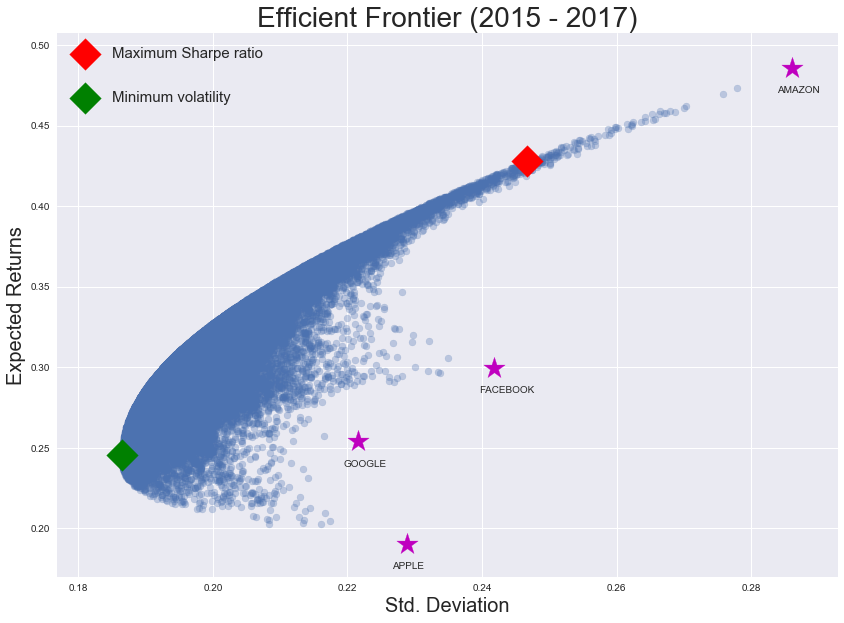

In [23]:
plt.figure(figsize=(14, 10))

plt.scatter(x=portfolio1[1,:], y=portfolio1[0,:], alpha=0.3)
plt.scatter(x=big4Port[1,:], y=big4Port[0,:], marker = '*', color ='m', s=500)
for i in range(4):
    plt.annotate(labels[i], xy=(big4Port[1,i], big4Port[0,i]),xytext=(-15,-25), textcoords='offset pixels')
plt.scatter(x = sStd, y = sRet, marker='D',color='r',s=500, label='Maximum Sharpe ratio')
plt.scatter(x = mStd, y = mRet, marker='D',color='g',s=500, label='Minimum volatility')

plt.xlabel('Std. Deviation', fontsize = 20)
plt.ylabel('Expected Returns', fontsize = 20)
plt.title('Efficient Frontier (2015 - 2017)', fontsize = 28)
plt.legend(labelspacing=2.0, fontsize = 15)
plt.show()

In [24]:
riskFreeRate = 0.0107

In [25]:
retsAnn2, covAnn2 = annData(big4Df2)

In [26]:
portfolio2, weights = randomPortf1(retsAnn2, covAnn2)

In [27]:
sRet2, sStd2 = getMaxSharp(portfolio2)
mRet2, mStd2 = getMinStd(portfolio2)
big4Port2 = bigFour(retsAnn2, covAnn2)

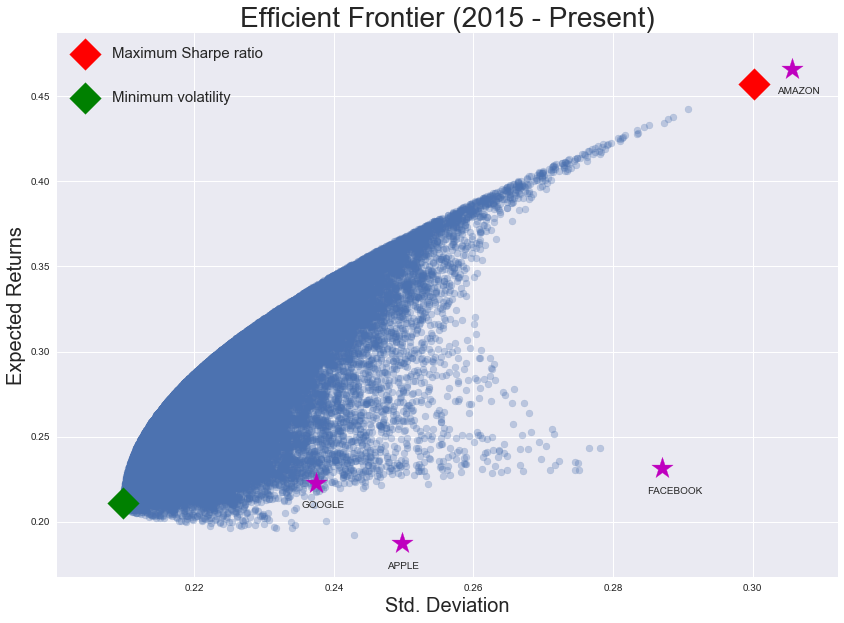

In [28]:
plt.figure(figsize=(14, 10))

plt.scatter(x=portfolio2[1,:], y=portfolio2[0,:], alpha=0.3)
plt.scatter(x=big4Port2[1,:], y=big4Port2[0,:], marker = '*', color ='m', s=500)
for i in range(4):
    plt.annotate(labels[i], xy=(big4Port2[1,i], big4Port2[0,i]),xytext=(-15,-25), textcoords='offset pixels')
plt.scatter(x = sStd2, y = sRet2, marker='D',color='r',s=500, label='Maximum Sharpe ratio')
plt.scatter(x = mStd2, y = mRet2, marker='D',color='g',s=500, label='Minimum volatility')

plt.xlabel('Std. Deviation', fontsize = 20)
plt.ylabel('Expected Returns', fontsize = 20)
plt.title('Efficient Frontier (2015 - Present)', fontsize = 28)
plt.legend(labelspacing=2.0, fontsize = 15)
plt.show()